In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

df = pd.read_csv("wine.csv", index_col=['month'], parse_dates=['month'], dayfirst=True, encoding="ISO-8859-1")
print(df.shape)
df.head()



(176, 1)


,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


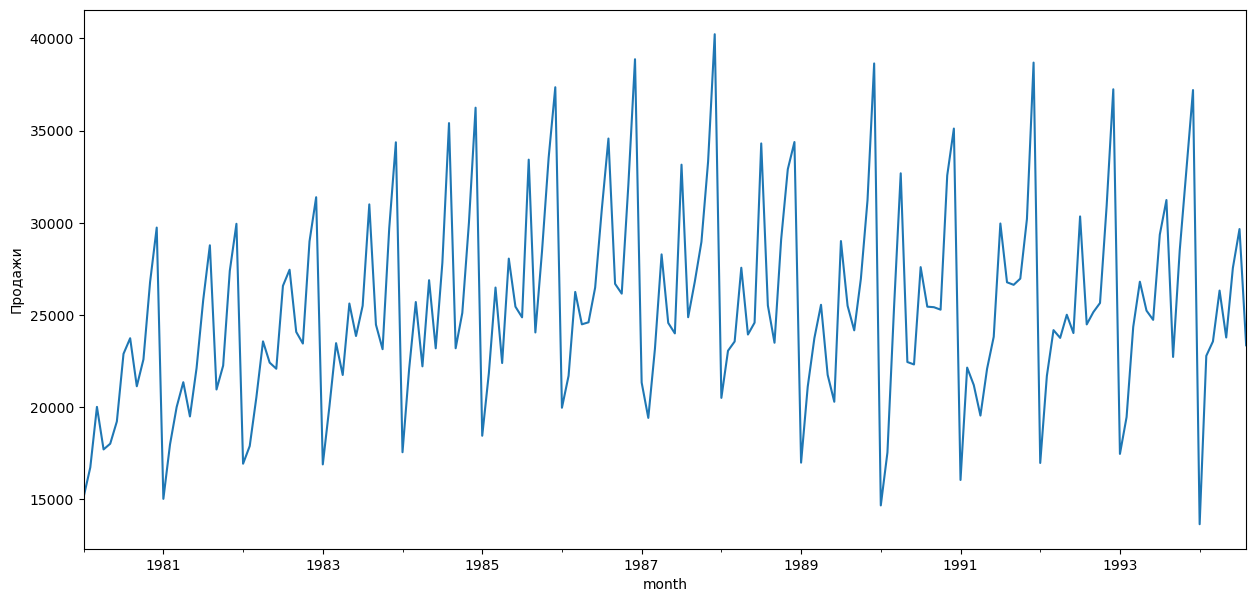

In [9]:
# выведем данные на график
plt.figure(figsize=(15,7))
df['sales'].plot()
plt.ylabel('Продажи')
plt.show()

Критерий Дики-Фуллера: p=0.051161


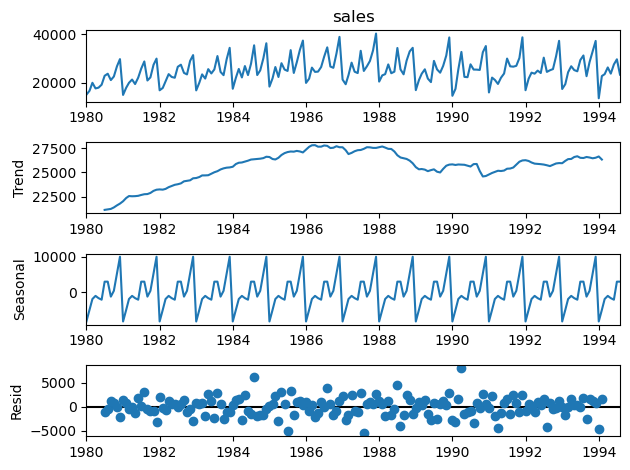

In [11]:
# Проверьте стационарность ряда
sm.tsa.seasonal_decompose(df['sales']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales'])[1])

По критерию Дики-Фуллера гипотеза о нестационарности ряда не отвергается. Значение 0.051161 больше порога 0.05.

Немного видны следующие особенности данных:
возрастающий тренд
Не очень стабильная дисперсия (В начале в течение года данные не очень сильно изменялись. А под конец максимальный замер уже отличается от минимального)
Сезонность (Замеры раз в 12 месяцев сильно похожи друг на друга. Например, пики на графики были записаны в один и тот же месяц)
заметная структура остатков

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


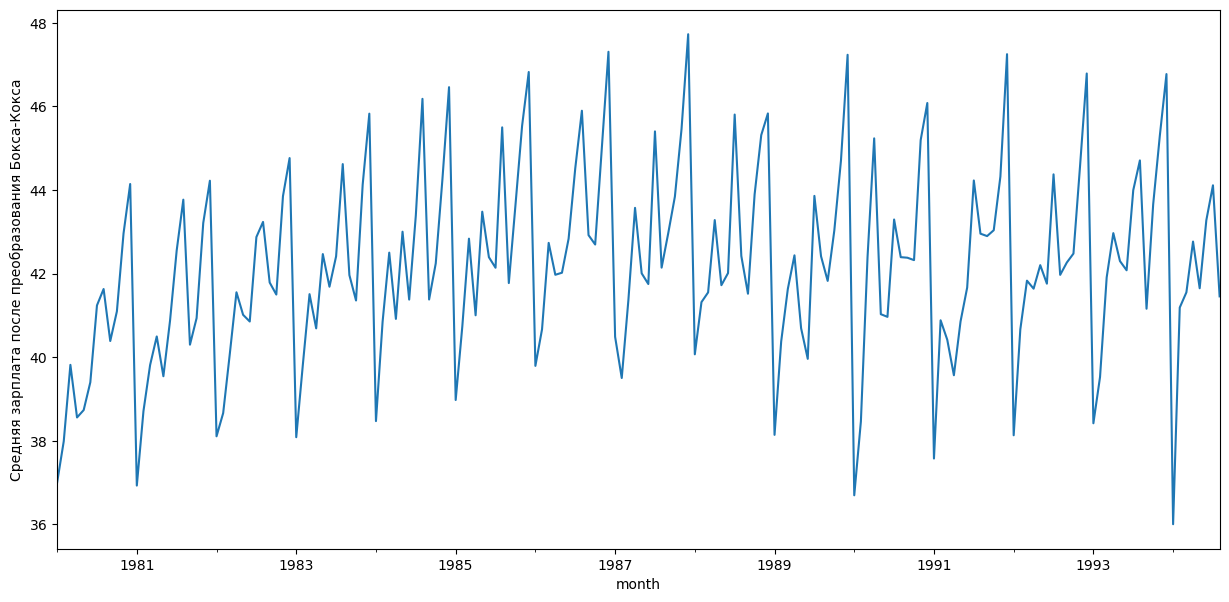

In [23]:
df['sales_box'], lmbda = stats.boxcox(df['sales'])
plt.figure(figsize=(15,7))
df['sales_box'].plot()
plt.ylabel(u'Средняя зарплата после преобразования Бокса-Кокса')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box'])[1])

Критерий Дики-Фуллера отвергает гипотезу не стационарности, но визуально в
данных виден тренд.

Выведем сразу два графика - оригинальный и после Кокса-Бокса:

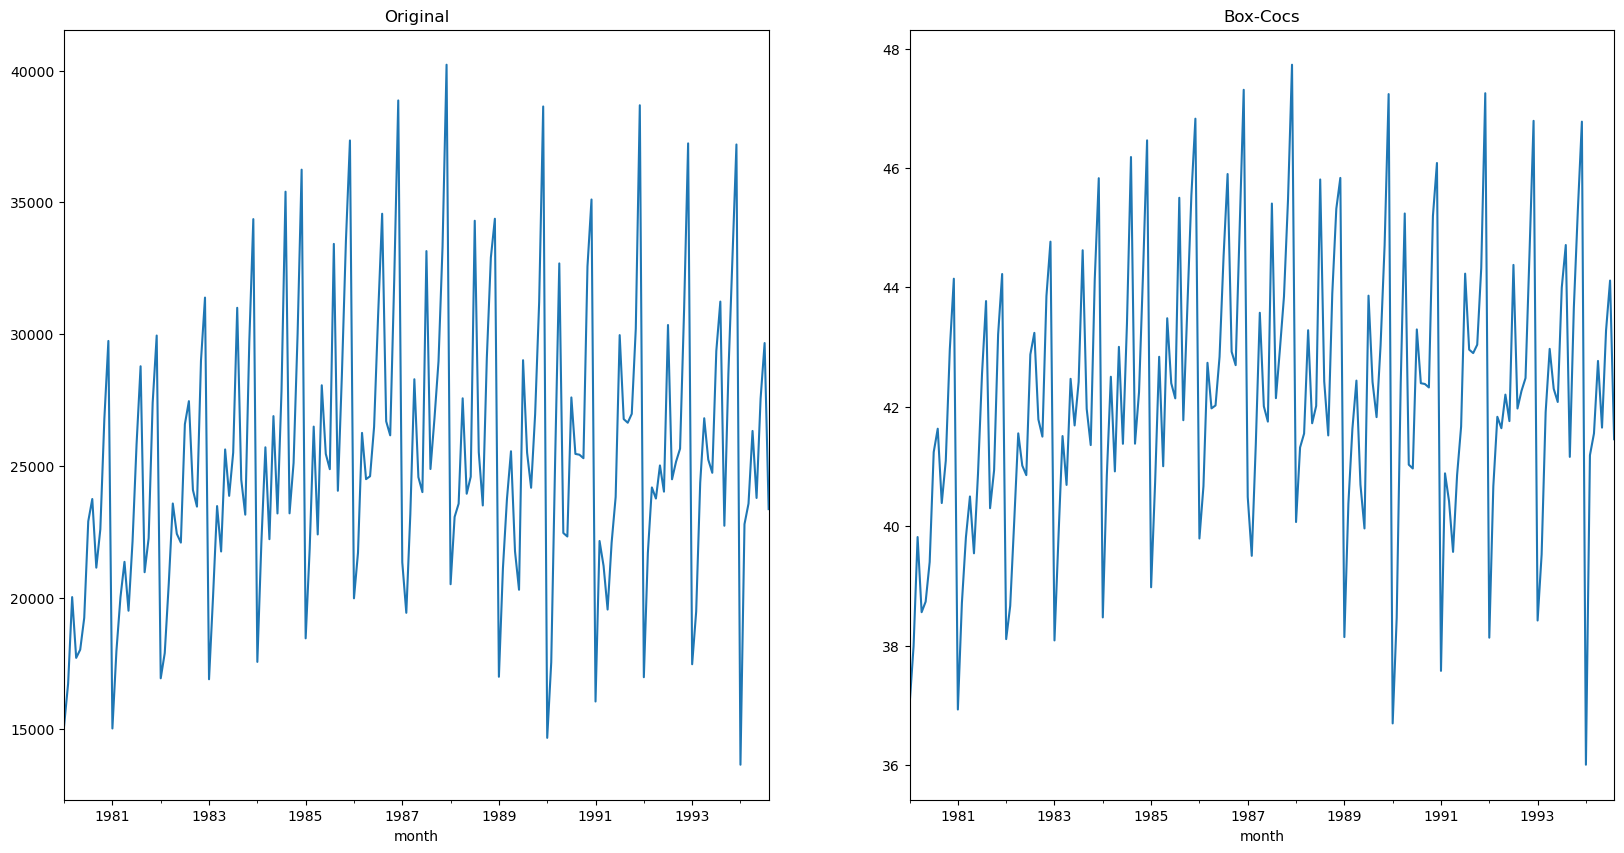

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df['sales'].plot(kind='line', ax=ax[0])
df['sales_box'].plot(kind='line', ax=ax[1])

ax[0].set_title('Original')
ax[1].set_title('Box-Cocs')

plt.show()

Попробуйте сезонное дифференцирование, на продифференцированном ряде проверьте стационарность.

Критерий Дики-Фуллера: p=0.128317


<Figure size 1500x1000 with 0 Axes>

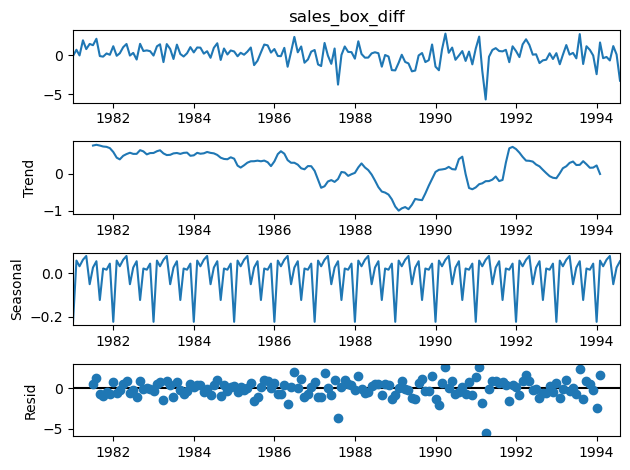

In [24]:
df['sales_box_diff'] = df['sales_box'] - df['sales_box'].shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df['sales_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box_diff'][12:])[1])

По критерию Дики-Фуллера нельзя отвергнеть гипотезу нестационарности (0.128317 > 0.05), в остатках стало заметно меньше структуры, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


<Figure size 1500x1000 with 0 Axes>

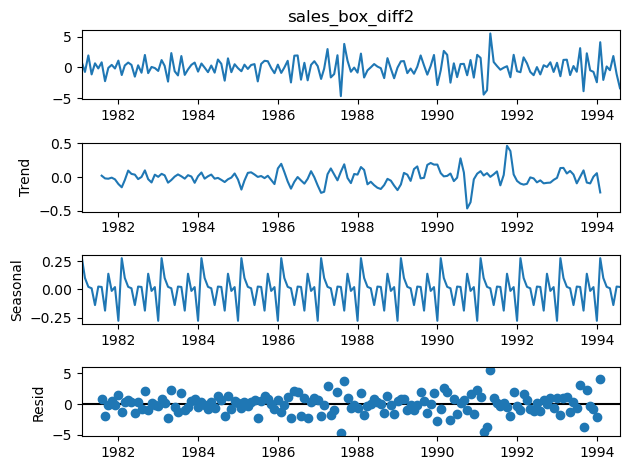

In [25]:
df['sales_box_diff2'] = df['sales_box_diff'] - df['sales_box_diff'].shift(1)
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(df['sales_box_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['sales_box_diff2'][13:])[1])

По критерию Дики-Фуллера можно отвергнеть гипотезу нестационарности (0.000002 < 0.05), в остатках заметна структура, избавиться от тренда удалось.

Для подбора модели постройте ACF и PACF полученного ряда. Возьмите
начальные приближение параметров модели. Постройте модель, проверьте ее
остатки на стационарность. (3 балла)

/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


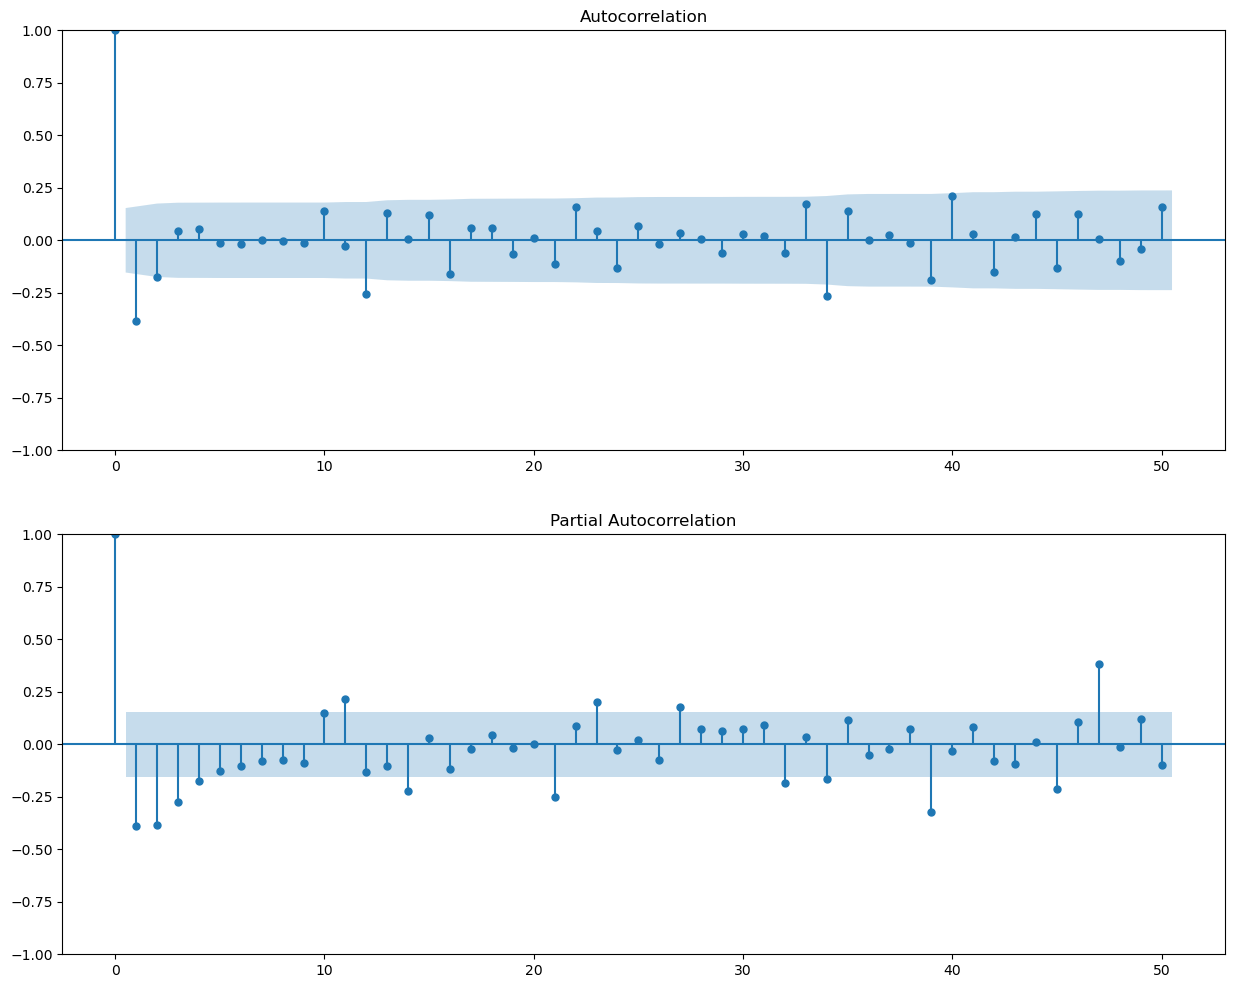

In [29]:
plt.figure(figsize=(15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['sales_box_diff2'][13:].values.squeeze(), lags=50, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['sales_box_diff2'][13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Выбираем параметры нашей модели:

__Q__ - значение последнего значимого сезонного лага на автокоррелограмме ACF. Т.к. значимый лаг, кратный периоду (12) один, то __Q = 1__

__q__ - значение последнего значимого несезонного лага на автокоррелограмме, меньшего величин периода __q = 10__

__P__ - значение последнего значимого сезонного лага на частичной автокоррелограмме PACF. В данном случае это лаг = 12, поэтому возьмем значение __P = 1__

__p__ - значение последнего значимого несезонного лага, меньшего величин периода, на частичной автокоррелограмме. __p = 10__


Начальные приближения: Q=1, q=10, P=1, p=10

In [30]:
p = 10
d = 1  # столько раз делали дифференциорование
q = 10
P = 1
D = 1  # столько раз делали сезонное дифференцирование
Q = 1

In [31]:
model=sm.tsa.statespace.SARIMAX(df['sales_box'], order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)

/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Критерий Дики-Фуллера: p=0.000000


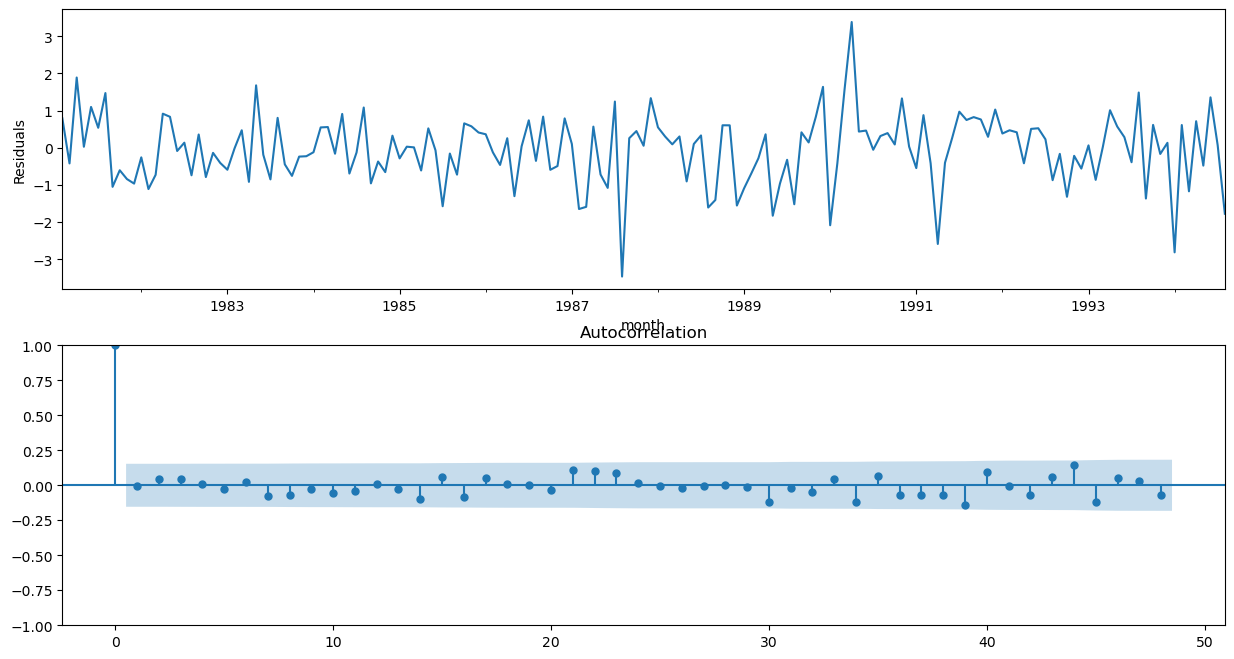

In [32]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Неплохо. Но возможно, стоит перебрать больше значений параметров для поиска оптимальной модели? Обычно после примерного определения значений параметров модели, проводят grid search по наборам близких к оптимальным значений.

In [34]:
from itertools import product

#устанавливаем границы массивов наших параметров
ps = range(10, 12)
d=1
qs = range(10, 12)
Ps = range(0, 2)
D=1
Qs = range(1, 2)

# столько комбинаций параметров будем перебирать
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

Следующий код выполняется долго, т.к. обучает много моделей. Лучшую из них мы будем выбирать на основе критерия Акаике. Чем меньше значение aic, тем лучше.

In [47]:
import warnings
from tqdm import tqdm
from ipywidgets import IntProgress
from IPython.display import display

progress_bar = IntProgress(min=0, max=len(parameters_list))
display(progress_bar)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

ii=0 # для prog_bar

for i, param in enumerate(tqdm(parameters_list)):
    progress_bar.value = i + 1

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['sales_box'], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

IntProgress(value=0, max=8)

100%|██████████| 8/8 [00:41<00:00,  5.14s/it]


Выведем 5 лучших моделей. Первой идет модель с наименьшим aic. Как мы видим, это оказалась модель с параметрами (10, 10, 1, 1), которые мы и выбрали изначально. У нас улучшить их значения не получилось, но то, что мы проделали часто помогает найти более удачную модель.

In [48]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
4  (11, 10, 0, 1)  481.428115
5  (11, 10, 1, 1)  482.780886
6  (11, 11, 0, 1)  483.829808
7  (11, 11, 1, 1)  485.090529
0  (10, 10, 0, 1)  485.106986


In [49]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              sales_box   No. Observations:                  176
Model:             SARIMAX(11, 1, 10)x(0, 1, [1], 12)   Log Likelihood                -217.714
Date:                                Fri, 10 Feb 2023   AIC                            481.428
Time:                                        14:27:13   BIC                            552.584
Sample:                                    01-01-1980   HQIC                           510.317
                                         - 08-01-1994                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7402      0.199     -3.726      0.000      -1.130      -0.351
ar.L2         -0.2570      0.254     -1.011      0.312      -0.755       0.241
ar.L3         -0.0850      0.274     -0.311      0.756      -0.621       0.451
ar.L4         -0.2707      0.322     -0.841      0.400      -0.901       0.360
ar.L5          0.1242      0.339      0.367      0.714      -0.540       0.788
ar.L6         -0.2202      0.266     -0.829      0.407      -0.741       0.300
ar.L7          0.1124      0.251      0.447      0.655      -0.380       0.605
ar.L8          0.5974      0.226      2.647      0.008       0.155       1.040
ar.L9          0.6631      0.245      2.705      0.007       0.183       1.144
ar.L10         0.0625      0.175      0.358      0.720      -0.280       0.405
ar.L11        -0.0709      0.158     -0.450      0.653      -0.380       0.238
ma.L1         -0.1560      0.362     -0.431      0.666      -0.865       0.553
ma.L2         -0.6464      0.558     -1.159      0.246      -1.739       0.446
ma.L3         -0.1018      0.267     -0.381      0.703      -0.625       0.422
ma.L4          0.2879      0.728      0.395      0.692      -1.139       1.715
ma.L5         -0.4219      0.322     -1.309      0.191      -1.054       0.210
ma.L6          0.3931      0.791      0.497      0.619      -1.157       1.943
ma.L7         -0.1668      0.284     -0.587      0.557      -0.724       0.390
ma.L8         -0.6297      0.640     -0.984      0.325      -1.884       0.625
ma.L9         -0.1518      0.367     -0.414      0.679      -0.871       0.567
ma.L10         0.8800      0.464      1.898      0.058      -0.029       1.789
ma.S.L12      -0.8254      0.104     -7.899      0.000      -1.030      -0.621
sigma2         0.7334      0.300      2.446      0.014       0.146       1.321
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                12.02
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Теперь посмотрим, как модель приближает данные.

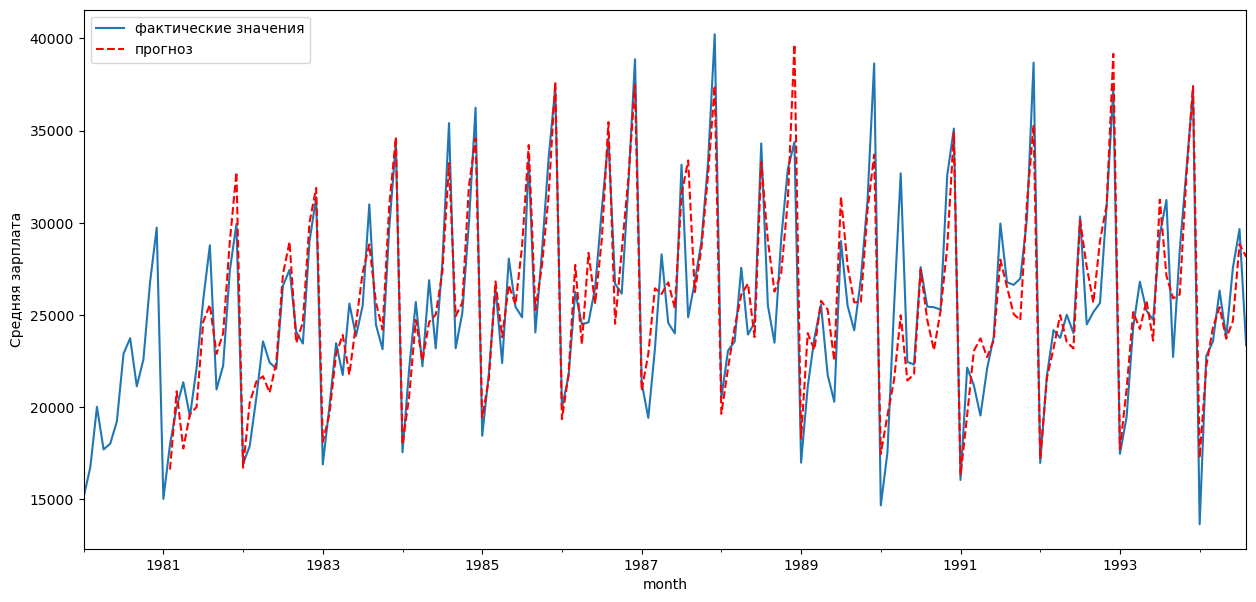

In [51]:
import numpy as np

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df['sales'].plot(label = 'фактические значения')
df['model'][13:].plot(color='r', label = 'прогноз', linestyle = '--')
plt.ylabel(u'Средняя зарплата')
plt.legend()
plt.show()

Визуально наша модель неплохо приближает реальные данные. Посмотрим прогноз.


Прежде всего посмотрим, как модель прогнозирует те данные, которые мы знаем. Разделим набор данных на обучающий и тестовый.

In [58]:
# обучающая выборка будет включать данные до декабря 1992 года включительно
train = df[:'1992-12-01']
# тестовая выборка начнется с января 1993 года
test = df['1992-12-01':]

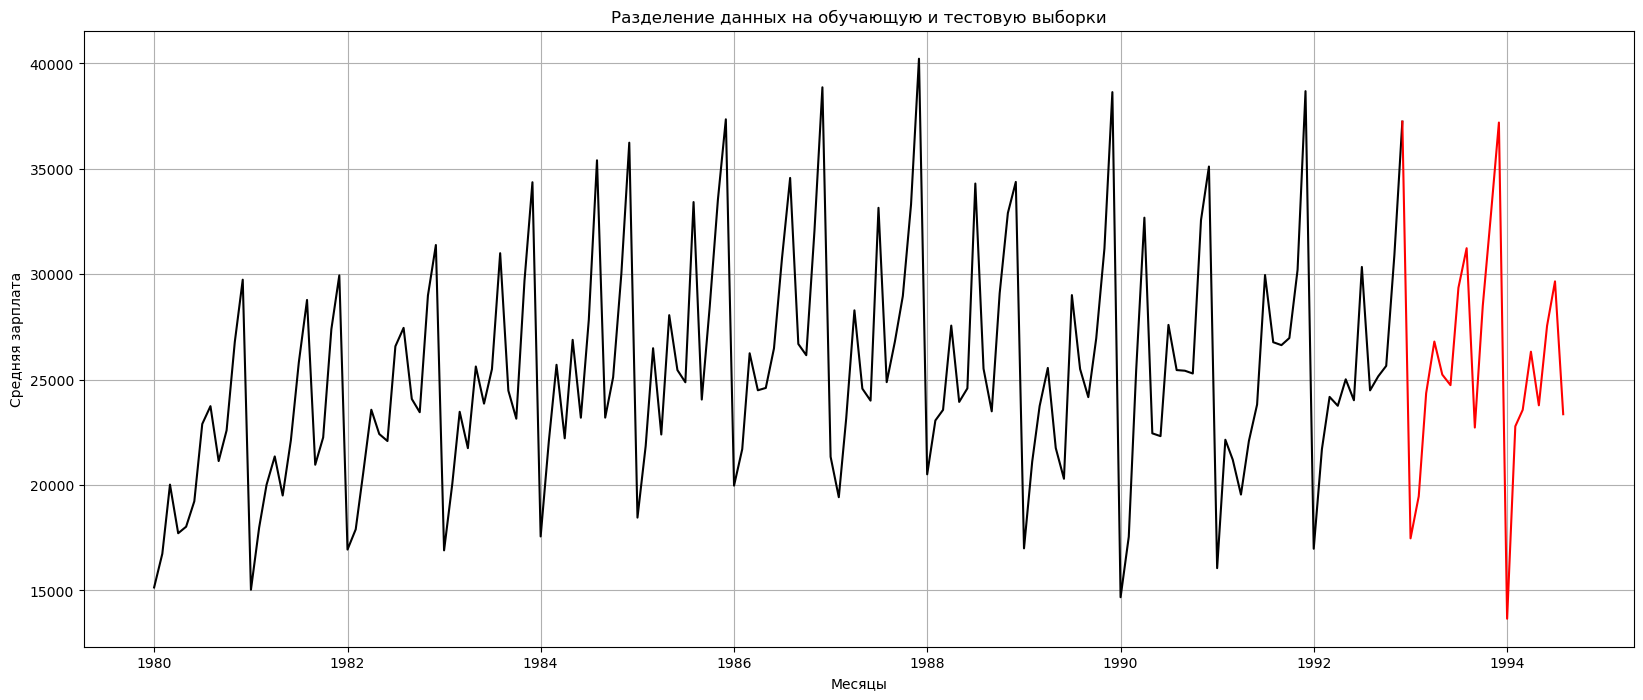

In [59]:
# Посмотрим на разделение на графике
plt.figure(figsize=(20,8))
plt.plot(train['sales'], color = "black")
plt.plot(test['sales'], color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Средняя зарплата')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [60]:
#устанавливаем значения параметров
p = 10
d = 1 # столько раз делали дифференциорование
q = 10
P = 1
D = 1 # столько раз делали сезонное дифференцирование
Q = 1

In [61]:
# Обучаем модель на train
model_1=sm.tsa.statespace.SARIMAX(df['sales_box'], order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)

/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aleksandr/.conda/envs/for_mycharm/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict и обратное преобразование Бокса-Кокса
predictions = invboxcox(model_1.predict(start, end), lmbda)
predictions

1993-01-01    17353.958935
1993-02-01    21137.352168
1993-03-01    24294.287578
1993-04-01    24462.758960
1993-05-01    23948.080786
1993-06-01    24096.261467
1993-07-01    30368.759101
1993-08-01    27416.730540
1993-09-01    25755.089025
1993-10-01    26977.759898
1993-11-01    33323.968283
1993-12-01    36788.011429
1994-01-01    18163.984629
1994-02-01    21513.817364
1994-03-01    26218.672690
1994-04-01    24672.097752
1994-05-01    24846.703733
1994-06-01    24374.770235
1994-07-01    29477.221715
1994-08-01    27437.154473
1994-09-01    25551.528115
Freq: MS, Name: predicted_mean, dtype: float64

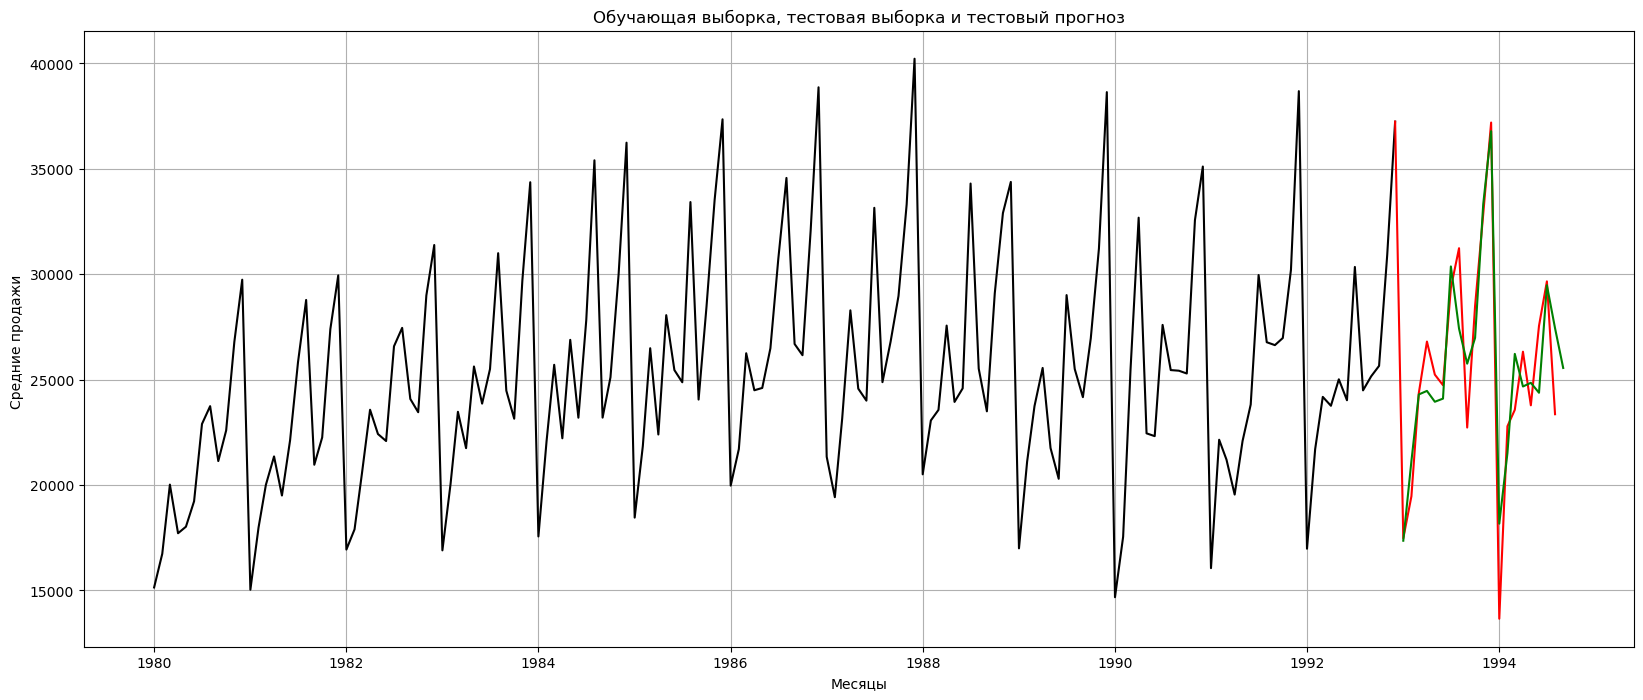

In [64]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(20,8))
plt.plot(train['sales'], color = "black")
plt.plot(test['sales'], color = "red")
plt.plot(predictions, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Средние продажи ')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

В целом модель хорошо описывает временной ряд. Мы также можем использовать  метрики среднеквадратической ошибки (MSE) и корня среднеквадратической ошибки (RMSE) для оценки качества.

In [68]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print('MSE', mean_squared_error(test['sales'], predictions))

# и RMSE
print('RMSE', np.sqrt(mean_squared_error(test['sales'], predictions)))

MSE 48441023.93212914
RMSE 6959.958615690839


В среднем ошибаемся примерно на 7000 рублей

Теперь можно делать прогноз на будущее. Возьмём горизонт равный 2 годам. Всего должно получиться 24 прогнозных значений.

In [75]:
# прогнозный период с конца имеющихся данных
start = len(df)

# и закончится 36 месяцев спустя
end = (len(df) - 1) + 2 * 12

# теперь построим прогноз на три года вперед
forecast = invboxcox(best_model.predict(start, end), lmbda)
forecast

1994-09-01    24683.659666
1994-10-01    28365.268193
1994-11-01    31862.018518
1994-12-01    36491.085085
1995-01-01    16848.165536
1995-02-01    20680.356792
1995-03-01    23136.088173
1995-04-01    25475.106453
1995-05-01    24303.372105
1995-06-01    24318.786660
1995-07-01    30481.645989
1995-08-01    25801.517642
1995-09-01    24651.192817
1995-10-01    26415.093161
1995-11-01    30475.608640
1995-12-01    37344.173668
1996-01-01    16360.099379
1996-02-01    21519.010763
1996-03-01    23402.968049
1996-04-01    24597.576215
1996-05-01    23664.325834
1996-06-01    23434.146102
1996-07-01    29458.991605
1996-08-01    26254.346406
Freq: MS, Name: predicted_mean, dtype: float64

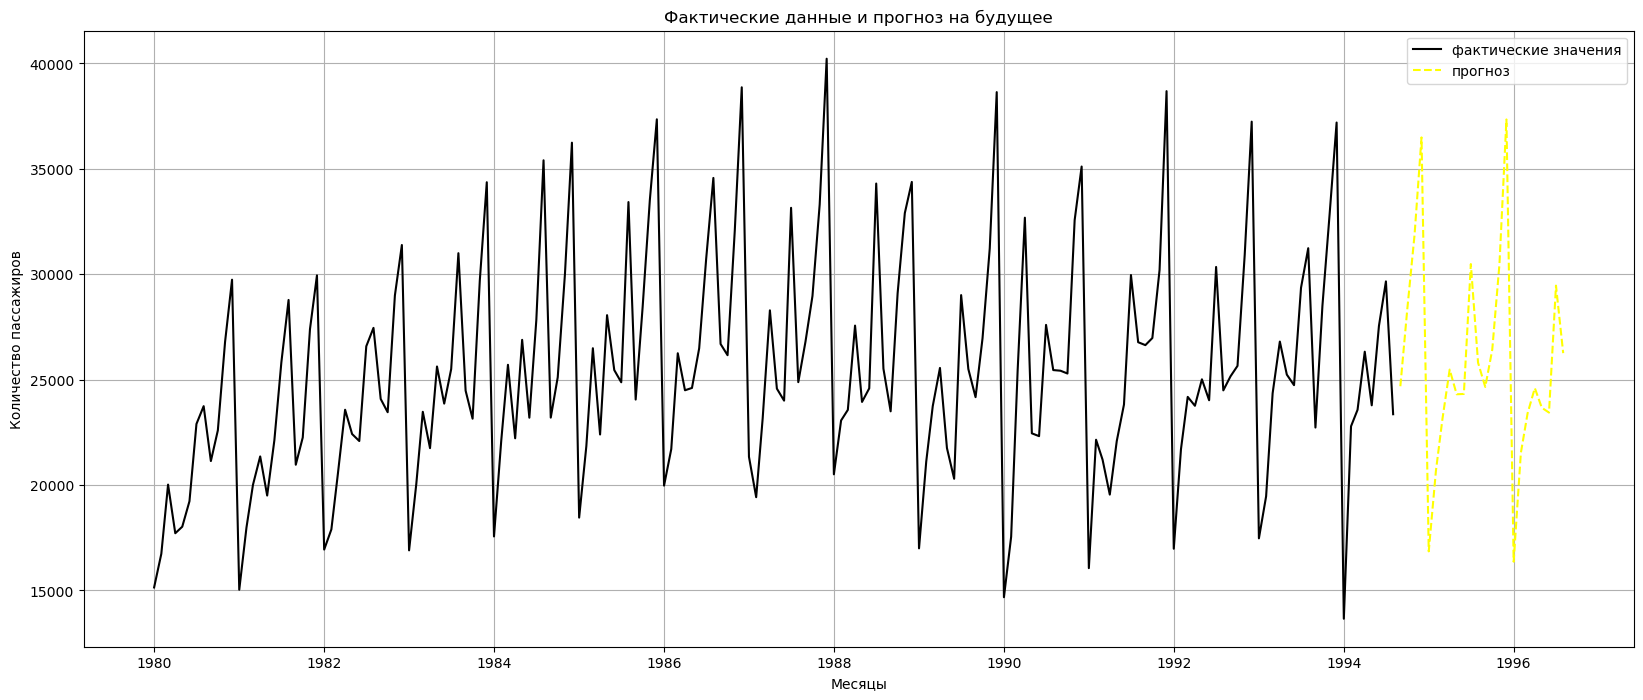

In [76]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(20,8))
plt.plot(df['sales'], color = 'black', label = 'фактические значения')
plt.plot(forecast, color = 'yellow', label = 'прогноз', linestyle = '--')
plt.legend()

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

Видно, что прогноз учитывает как сезонные колебания в данных, так и возрастающий тренд. Прогноз выглядит адекватно.